# Recommending movies: ranking

reference to https://www.tensorflow.org/recommenders/examples/quickstart


## Imports


Let's first get our imports out of the way.

In [1]:
!pip install -q --upgrade tensorflow==2.3.0
!pip install -q --upgrade tensorflow-datasets
!pip install -q --upgrade tensorflow-recommenders

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow_recommenders as tfrs

## Preparing the dataset


In [4]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"]
})


for x in ratings.take(10).as_numpy_iterator():
    pprint.pprint(x)

{'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'timestamp': 879024327,
 'user_id': b'138',
 'user_rating': 4.0}
{'movie_id': b'709',
 'movie_title': b'Strictly Ballroom (1992)',
 'timestamp': 875654590,
 'user_id': b'92',
 'user_rating': 2.0}
{'movie_id': b'412',
 'movie_title': b'Very Brady Sequel, A (1996)',
 'timestamp': 882075110,
 'user_id': b'301',
 'user_rating': 4.0}
{'movie_id': b'56',
 'movie_title': b'Pulp Fiction (1994)',
 'timestamp': 883326919,
 'user_id': b'60',
 'user_rating': 4.0}
{'movie_id': b'895',
 'movie_title': b'Scream 2 (1997)',
 'timestamp': 891409199,
 'user_id': b'197',
 'user_rating': 3.0}
{'movie_id': b'325',
 'movie_title': b'Crash (1996)',
 'timestamp': 876346551,
 'user_id': b'601',
 'user_rating': 4.0}
{'movie_id': b'95',
 'movie_title': b'Aladdin (1992)',
 'timestamp': 882064434,
 'user_id': b'710',
 'user_rating': 3.0}
{'movie_id': b'92',
 'movie_title': b'True Romance (1993)',
 'timestamp': 875135363,
 'user_id': b'

### Movie ID Model 

In [5]:
import numpy as np
import tensorflow as tf

movie_id_lookup = tf.keras.layers.experimental.preprocessing.StringLookup()

In [6]:
movie_id_lookup.adapt(ratings.map(lambda x: x["movie_id"]))

print(f"Vocabulary: {movie_id_lookup.get_vocabulary()[:10]}")

Vocabulary: ['', '[UNK]', '50', '258', '100', '181', '294', '286', '288', '1']


In [7]:
movie_id_lookup(["50", "258"])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 3])>

In [8]:
movie_id_embedding = tf.keras.layers.Embedding(
    # Let's use the hashing approach.
    input_dim=movie_id_lookup.vocab_size(),
    output_dim=32
)

In [9]:
movie_id_model = tf.keras.Sequential([movie_id_lookup, movie_id_embedding])

In [10]:
movie_id_model(["258"])

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.03683779,  0.01574442, -0.00191128, -0.02334578,  0.03131615,
         0.01971257,  0.04456771, -0.03512559,  0.0281582 ,  0.00722883,
        -0.02040149,  0.04162142, -0.03039396, -0.00856012,  0.03898208,
        -0.0208787 ,  0.00993685,  0.03259205,  0.01114772, -0.03700482,
        -0.02726729, -0.02220753, -0.00267942, -0.03838231, -0.0086822 ,
         0.02176252,  0.04841442, -0.01994302, -0.04707646, -0.01819193,
        -0.04038259,  0.01285899]], dtype=float32)>

### User ID Model 

In [11]:
num_hashing_bins = 20_000
user_id_lookup = tf.keras.layers.experimental.preprocessing.StringLookup()
user_id_embedding = tf.keras.layers.Embedding(num_hashing_bins, 32)

user_id_lookup.adapt(ratings.map(lambda x: x["user_id"]))

user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])
user_id_model(["1"])


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.01494462,  0.01383928,  0.00724288, -0.03497411,  0.00623759,
        -0.00176605,  0.0142752 , -0.02305305, -0.04249296,  0.04306104,
         0.00490896,  0.01428751, -0.04450608,  0.00272029, -0.01044626,
        -0.00680286,  0.04168485, -0.01107093, -0.00332416, -0.00266393,
        -0.00450672,  0.03725065, -0.0428389 , -0.0445559 , -0.03071376,
         0.01442896, -0.04305726,  0.02370479,  0.03161678, -0.03510436,
         0.02899389,  0.01096638]], dtype=float32)>

We'll split the data by putting 80% of the ratings in the train set, and 20% in the test set.

In [12]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [13]:
for x in ratings.take(3).as_numpy_iterator():
    print(f"Timestamp: {x['timestamp']}.")

Timestamp: 879024327.
Timestamp: 875654590.
Timestamp: 882075110.


In [14]:
max_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int64), tf.maximum).numpy().max()
min_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    np.int64(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [8.74724710e+08 8.74743291e+08 8.74761871e+08]


In [15]:
timestamp_embedding_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
  tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])

for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():
    print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}.")                                       

Cause: could not parse the source code:

for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Timestamp embedding: [[ 0.0420709   0.03051918  0.0251932  -0.04404786 -0.04481405  0.0274605
  -0.04872919 -0.03761928 -0.03910366  0.0122426   0.04560845 -0.03405318
  -0.02518764  0.01535762 -0.00833679  0.04527276 -0.04457959 -0.02121785
   0.03542933 -0.01348841  0.00695822 -0.04937354 -0.03111904  0.02598378
  -0.00340524  0.00515842  0.0189133  -0.01394101 -0.03740637  0.01499177
  -0.02341032 -0.03579756]].


In [16]:
title_text = tf.keras.layers.experimental.preprocessing.TextVectorization()
title_text.adapt(ratings.map(lambda x: x["movie_title"]))

In [17]:
for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):
    print(title_text(row))

Cause: could not parse the source code:

for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf.Tensor([[ 32 266 162   2 267 265  53]], shape=(1, 7), dtype=int64)


In [18]:
title_text.get_vocabulary()[40:45]

['first', '1998', '1977', '1971', 'monty']

In [19]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        num_hashing_bins = 20_000

        self.user_embedding = tf.keras.Sequential([
            user_id_lookup,
            tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32),
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 2, 32)
        ])
    
    def call(self, inputs):
      # Take the input dictionary, pass it through each input layer,
      # and concatenate the result.

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
        ], axis=1)

In [20]:
class MovieModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.id_embedding = tf.keras.Sequential([
            movie_id_lookup,
            tf.keras.layers.Embedding(movie_id_lookup.vocab_size(), 32)
        ])
        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens),
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          # We average the embedding of individual words to get one embedding vector
          # per title.
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

    def call(self, inputs):
        return tf.concat([
            self.id_embedding(inputs["movie_id"]),
            self.title_text_embedding(inputs["movie_title"]),
    ], axis=1)

In [21]:
for row in ratings.batch(10).map(lambda x: x["movie_title"]).take(1):
  print(title_text(row))

Cause: could not parse the source code:

for row in ratings.batch(10).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for row in ratings.batch(10).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

for row in ratings.batch(10).map(lambda x: x["movie_title"]).take(1):

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf.Tensor(
[[ 32 266 162   2 267 265  53]
 [745 752  12   0   0   0   0]
 [801 482 806  10   3   0   0]
 [130 131   6   0   0   0   0]
 [ 69  36   4   0   0   0   0]
 [629   3   0   0   0   0   0]
 [307  12   0   0   0   0   0]
 [164 746   8   0   0   0   0]
 [875 871  12   0   0   0   0]
 [373 372   4   0   0   0   0]], shape=(10, 7), dtype=int64)


In [22]:
movie_model = MovieModel()

movie_model.title_text_embedding.layers[0].adapt(
    ratings.map(lambda x: x["movie_title"]))

for row in ratings.batch(1).take(1):
    print(f"Computed representations: {movie_model(row)[0, :3]}")

Computed representations: [-0.01447626  0.02125495 -0.00797076]


## Implementing a model

### Architecture

Ranking models do not face the same efficiency constrains as retrieval models do, and so we have a little bit more freedom in our choice of architectures.

A model composed of multiple stacked dense layers is a relatively common architecture for ranking tasks. We can implement it as follows:

In [23]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = UserModel()

        # Compute embeddings for movies.
        self.movie_embeddings = MovieModel()

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
          # Learn multiple dense layers.
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
          # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ])
        
    def call(self, inputs):
        user_embedding = self.user_embeddings(inputs)
        movie_embedding = self.movie_embeddings(inputs)
        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

This model takes user ids and movie titles, and outputs a predicted rating:

### Loss and metrics

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Ranking` task object: a convenience wrapper that bundles together the loss function and metric computation. 

We'll use it together with the `MeanSquaredError` Keras loss in order to predict the ratings.

```python
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
```

The task itself is a Keras layer that takes true and predicted as arguments, and returns the computed loss. We'll use that to implement the model's training loop.

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines bulding models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [24]:
class MovielensModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            features)
        print('rating_predictions', rating_predictions)
        # The task computes the loss and the metrics.
        return self.task(labels=features["user_rating"], predictions=rating_predictions)

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [25]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Then shuffle, batch, and cache the training and evaluation data.

In [26]:
cached_train = train.shuffle(100_000).batch(10_000).cache()
cached_test = test.batch(4096).cache()

Then train the  model:

In [27]:
model.fit(cached_train, epochs=200)

Epoch 1/200
rating_predictions Tensor("ranking_model/sequential_9/dense_2/BiasAdd:0", shape=(None, 1), dtype=float32)
rating_predictions Tensor("ranking_model/sequential_9/dense_2/BiasAdd:0", shape=(None, 1), dtype=float32)
8/8 [==============================] - 1s 70ms/step - root_mean_squared_error: 3.6253 - loss: 13.0566 - regularization_loss: 0.0000e+00 - total_loss: 13.0566
Epoch 2/200
8/8 [==============================] - 0s 41ms/step - root_mean_squared_error: 3.2983 - loss: 10.7006 - regularization_loss: 0.0000e+00 - total_loss: 10.7006
Epoch 3/200
8/8 [==============================] - 0s 42ms/step - root_mean_squared_error: 2.4917 - loss: 5.9085 - regularization_loss: 0.0000e+00 - total_loss: 5.9085
Epoch 4/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 1.3396 - loss: 1.8187 - regularization_loss: 0.0000e+00 - total_loss: 1.8187
Epoch 5/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 1.3332 - loss: 1.7083

8/8 [==============================] - 0s 38ms/step - root_mean_squared_error: 0.8948 - loss: 0.8008 - regularization_loss: 0.0000e+00 - total_loss: 0.8008
Epoch 49/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.8938 - loss: 0.7991 - regularization_loss: 0.0000e+00 - total_loss: 0.7991
Epoch 50/200
8/8 [==============================] - 0s 41ms/step - root_mean_squared_error: 0.8927 - loss: 0.7972 - regularization_loss: 0.0000e+00 - total_loss: 0.7972
Epoch 51/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.8915 - loss: 0.7950 - regularization_loss: 0.0000e+00 - total_loss: 0.7950
Epoch 52/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.8901 - loss: 0.7925 - regularization_loss: 0.0000e+00 - total_loss: 0.7925
Epoch 53/200
8/8 [==============================] - 0s 42ms/step - root_mean_squared_error: 0.8885 - loss: 0.7898 - regularization_loss: 0.0000e+00 - total_loss: 0.7898

8/8 [==============================] - 0s 41ms/step - root_mean_squared_error: 0.8318 - loss: 0.6925 - regularization_loss: 0.0000e+00 - total_loss: 0.6925
Epoch 97/200
8/8 [==============================] - 0s 44ms/step - root_mean_squared_error: 0.8299 - loss: 0.6894 - regularization_loss: 0.0000e+00 - total_loss: 0.6894
Epoch 98/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.8281 - loss: 0.6863 - regularization_loss: 0.0000e+00 - total_loss: 0.6863
Epoch 99/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.8264 - loss: 0.6834 - regularization_loss: 0.0000e+00 - total_loss: 0.6834
Epoch 100/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.8246 - loss: 0.6805 - regularization_loss: 0.0000e+00 - total_loss: 0.6805
Epoch 101/200
8/8 [==============================] - 0s 42ms/step - root_mean_squared_error: 0.8225 - loss: 0.6771 - regularization_loss: 0.0000e+00 - total_loss: 0.67

8/8 [==============================] - 0s 42ms/step - root_mean_squared_error: 0.7131 - loss: 0.5096 - regularization_loss: 0.0000e+00 - total_loss: 0.5096
Epoch 145/200
8/8 [==============================] - 0s 44ms/step - root_mean_squared_error: 0.7102 - loss: 0.5054 - regularization_loss: 0.0000e+00 - total_loss: 0.5054
Epoch 146/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.7071 - loss: 0.5011 - regularization_loss: 0.0000e+00 - total_loss: 0.5011
Epoch 147/200
8/8 [==============================] - 0s 44ms/step - root_mean_squared_error: 0.7043 - loss: 0.4972 - regularization_loss: 0.0000e+00 - total_loss: 0.4972
Epoch 148/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.7014 - loss: 0.4931 - regularization_loss: 0.0000e+00 - total_loss: 0.4931
Epoch 149/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.6982 - loss: 0.4887 - regularization_loss: 0.0000e+00 - total_loss: 0

8/8 [==============================] - 0s 41ms/step - root_mean_squared_error: 0.5606 - loss: 0.3161 - regularization_loss: 0.0000e+00 - total_loss: 0.3161
Epoch 193/200
8/8 [==============================] - 0s 41ms/step - root_mean_squared_error: 0.5562 - loss: 0.3111 - regularization_loss: 0.0000e+00 - total_loss: 0.3111
Epoch 194/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.5549 - loss: 0.3089 - regularization_loss: 0.0000e+00 - total_loss: 0.3089
Epoch 195/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.5533 - loss: 0.3084 - regularization_loss: 0.0000e+00 - total_loss: 0.3084
Epoch 196/200
8/8 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.5473 - loss: 0.3005 - regularization_loss: 0.0000e+00 - total_loss: 0.3005
Epoch 197/200
8/8 [==============================] - 0s 40ms/step - root_mean_squared_error: 0.5453 - loss: 0.2988 - regularization_loss: 0.0000e+00 - total_loss: 0

As the model trains, the loss is falling and the RMSE metric is improving.

Finally, we can evaluate our model on the test set:

In [28]:
model.evaluate(cached_test, return_dict=True)

rating_predictions Tensor("ranking_model/sequential_9/dense_2/BiasAdd:0", shape=(None, 1), dtype=float32)
5/5 [==============================] - 0s 24ms/step - root_mean_squared_error: 1.1041 - loss: 1.2218 - regularization_loss: 0.0000e+00 - total_loss: 1.2218


{'root_mean_squared_error': 1.1041373014450073,
 'loss': 1.2332557439804077,
 'regularization_loss': 0,
 'total_loss': 1.2332557439804077}

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


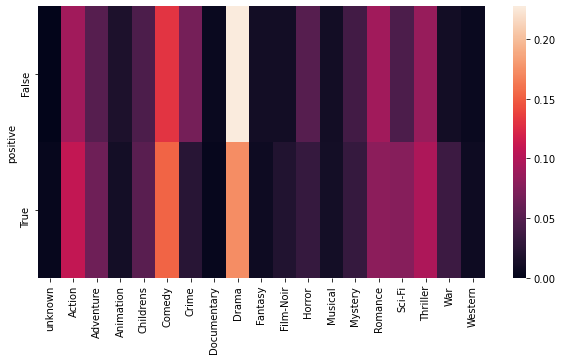

In [29]:
import json

import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rerank_user = 88
user_id = str(rerank_user)
user_item_df = pd.read_pickle("~/SageMaker/20201020-dnb-ranking-optimization/user_item_df.p")
item_df = pd.read_pickle("~/SageMaker/20201020-dnb-ranking-optimization/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def plot_heat_map(df, figsize=(10,7)): 
    df = df.div(df.sum(axis=1), axis=0)     
    plt.subplots(figsize=figsize)
    sns.heatmap(df)


u_id = user_id

tester_df = user_item_df[user_item_df['uid']==int(u_id)]
tester_df['positive'] = tester_df['rating'] >3 

review = tester_df[['positive']+genres].groupby(['positive']).sum()
plot_heat_map(review, figsize=(10,5))

In [30]:
master_user="master_user"
master_user_password="master_user_password"
elastic_search_endpoint="elastic_search_endpoint"

In [31]:
import requests 

r = requests.get('https://{}/movies/movie/_search?q=Comedy:1&size=100'.format(elastic_search_endpoint), auth=(master_user, master_user_password))
rjson = r.json()
rjson 


{'took': 18,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1515, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'movies',
    '_type': 'movie',
    '_id': 'wj6nPnUBarWwkoNP3sAX',
    '_score': 1.0,
    '_source': {'iid': 8,
     'title': 'Babe (1995)',
     'release_date': '01-Jan-1995',
     'video_release_date': '',
     'imdb url': 'http://us.imdb.com/M/title-exact?Babe%20(1995)',
     'unknown': 0,
     'Action': 0,
     'Adventure': 0,
     'Animation': 0,
     'Childrens': 1,
     'Comedy': 1,
     'Crime': 0,
     'Documentary': 0,
     'Drama': 1,
     'Fantasy': 0,
     'Film-Noir': 0,
     'Horror': 0,
     'Musical': 0,
     'Mystery': 0,
     'Romance': 0,
     'Sci-Fi': 0,
     'Thriller': 0,
     'War': 0,
     'Western': 0,
     'year': 1995}},
   {'_index': 'movies',
    '_type': 'movie',
    '_id': 'o-6nPnUBB522-ThU3glx',
    '_score': 1.0,
    '_source': {'iid': 13,
     'title': '

In [32]:
items_from_search = [] 
for h in rjson['hits']['hits']:
    items_from_search.append(h['_source']['iid'])



In [33]:
import time 

def get_input_dic_by_movie_user_id(user_id, movie_id, movie_df=item_df):
    """
    This takes in an artist_id from Personalize so it will be a string,
    converts it to an int, and then does a lookup in a default or specified
    dataframe.
    
    A really broad try/except clause was added in case anything goes wrong.
    
    Feel free to add more debugging or filtering here to improve results if
    you hit an error.
    """

    title_str = movie_df[movie_df['iid']==int(movie_id)].iloc[0]['title']
    mid = tf.convert_to_tensor([str(movie_id)])
    uid = tf.convert_to_tensor([str(user_id)])
    title = tf.convert_to_tensor([movie_df[movie_df['iid']==int(movie_id)].iloc[0]['title']])
    timestamp = tf.convert_to_tensor([time.time()])
    res = {} 
    res['movie_id'] = mid
    res['user_id'] = uid
    res['movie_title'] = title 
    res['timestamp'] = timestamp
    return res





def get_movie_by_id(movie_id, movie_df=item_df):
    """
    This takes in an artist_id from Personalize so it will be a string,
    converts it to an int, and then does a lookup in a default or specified
    dataframe.
    
    A really broad try/except clause was added in case anything goes wrong.
    
    Feel free to add more debugging or filtering here to improve results if
    you hit an error.
    """
    try:
        c_row = movie_df[movie_df['iid']==movie_id].iloc[0]
        title = c_row['title'] 
        m_genres = [] 
        for g in genres: 
            if c_row[g] == 1: 
                m_genres.append(g)
        return movie_df[movie_df['iid']==movie_id].iloc[0]['title'] + " genres:" + ",".join(m_genres)
    except:
        return "Error obtaining movie info"

In [34]:
rerank_list = []
for item in items_from_search:
    movie = get_movie_by_id(item)
    rerank_list.append(movie)
rerank_df = pd.DataFrame(rerank_list, columns = [rerank_user])
rerank_df

,88
0,"Babe (1995) genres:Childrens,Comedy,Drama"
1,Mighty Aphrodite (1995) genres:Comedy
2,"To Wong Foo, Thanks for Everything! Julie Newm..."
3,"Santa Clause, The (1994) genres:Childrens,Comedy"
4,Four Weddings and a Funeral (1994) genres:Come...
...,...
95,Á köldum klaka (Cold Fever) (1994) genres:Come...
96,"Favor, The (1994) genres:Comedy,Romance"
97,"Little City (1998) genres:Comedy,Romance"
98,"Toy Story (1995) genres:Animation,Childrens,Co..."


In [35]:
import numpy 
ranked_list = []
for item in items_from_search: 
    movie = get_movie_by_id(item)
    inf_input = get_input_dic_by_movie_user_id(str(rerank_user),str(item))
    score = model.ranking_model(inf_input)
    ranked_list.append([movie, score.numpy()[0][0]])

ranked_list = sorted(ranked_list, key=lambda x:x[1], reverse=True)   
ranked_df = pd.DataFrame(numpy.array(ranked_list)[:,0], columns = ['Re-Ranked'])
all_df = pd.concat([rerank_df, ranked_df], axis=1)
pd.set_option('display.max_colwidth', -1)
all_df

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,88,Re-Ranked
0,"Babe (1995) genres:Childrens,Comedy,Drama",Spy Hard (1996) genres:Comedy
1,Mighty Aphrodite (1995) genres:Comedy,"Faster Pussycat! Kill! Kill! (1965) genres:Action,Comedy,Drama"
2,"To Wong Foo, Thanks for Everything! Julie Newmar (1995) genres:Comedy",Jimmy Hollywood (1994) genres:Comedy
3,"Santa Clause, The (1994) genres:Childrens,Comedy","Junior (1994) genres:Comedy,Sci-Fi"
4,"Four Weddings and a Funeral (1994) genres:Comedy,Romance","To Wong Foo, Thanks for Everything! Julie Newmar (1995) genres:Comedy"
...,...,...
95,"Á köldum klaka (Cold Fever) (1994) genres:Comedy,Drama","Ghost (1990) genres:Comedy,Romance,Thriller"
96,"Favor, The (1994) genres:Comedy,Romance",Stuart Saves His Family (1995) genres:Comedy
97,"Little City (1998) genres:Comedy,Romance","Get Shorty (1995) genres:Action,Comedy,Drama"
98,"Toy Story (1995) genres:Animation,Childrens,Comedy","Van, The (1996) genres:Comedy,Drama"


The lower the RMSE metric, the more accurate our model is at predicting ratings.